In [1]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import seaborn as sns
import os
from utils import *
import matplotlib.pyplot as plt
import tol_colors as tc
import treeswift
import re
import string

from datetime import datetime
from dateutil.relativedelta import relativedelta

cset = sns.color_palette("Set1", n_colors=8, desat=.5)
from matplotlib.lines import Line2D
plt.rcParams['font.family'] = 'Arial'

cmap3 = ['#d62828', '#1d3557', '#f4a261', '#9cb29e']

# MCC tree importations

In [2]:
def read_mcc_tree(tree):
    if (type(tree) != treeswift.Tree) and ((type(tree) != str)):
        raise ValueError('The provided tree must be a treeswift tree object, a path to a tree file, or a newick string')

    if type(tree) is str:
        if os.path.exists(tree):
            tree_d = treeswift.read_tree_nexus(tree)
            tree = tree_d['TREE1']
        else:
            try:
                tree = treeswift.read_tree_newick(tree)
            except:
                raise ValueError('The provided tree path does not exist or the newick string is invalid')
    
    for n in tree.traverse_preorder():
        node_params = (n.node_params)
        rx_comma = re.compile(r'(?:[^,{]|\{[^}]*\})+')
        result = rx_comma.findall(node_params)
        n.node_params = {}
        for param in result:
            key, value = param.split('=')
            key = key.strip('&')
            value = value.replace('"', '')
            if '{' in value:
                value = value.strip('{').strip('}').split(',')
            if type(value) is not list:
                try: 
                    value = float(value)
                except:
                    pass
            else:
                try:
                    value = [float(x) for x in value]
                except:
                    pass
            n.node_params[key] = value
    # tree_d['TREE1'] = tree
    return tree


def mcc_import_cluster_leaves(node, loc="NYC", min_prob=0.5):
    '''
    Find the leaves of a tree that are part of an import cluster

    Parameters
    ----------
    tree: treeswift tree object
    node: node object
        The node of interest
    loc: str
        The location of interest
    min_prob: float
        The minimum probability of a location state for it to be considered an import

    Returns
    -------
    cluster: list
        A list of leaf labels corresponding to the import cluster
    '''

    # make sure the provided node is an internal node and has the specified location
    if node.is_leaf():
        raise ValueError('The provided node must be an internal node')
    else:
        try: 
            if loc not in node.node_params['loc.set']:
                raise ValueError('The provided node must have the specified location')
            else:
                if node.node_params['loc.set.prob'][node.node_params['loc.set'].index(loc)] <= min_prob:
                    raise ValueError('The provided node must have the specified location with a probability greater than the minimum probability')
        except:
            if loc not in node.node_params['loc.states.set']:
                raise ValueError('The provided node must have the specified location')
            else:
                if node.node_params['loc.states.set.prob'][node.node_params['loc.states.set'].index(loc)] <= min_prob:
                    raise ValueError('The provided node must have the specified location with a probability greater than the minimum probability')
                
    # find the leaves of the tree that are part of the import cluster, ignoring nodes once they leave the specified location
    cluster = []
    stack = [node]

    while stack:
        node = stack.pop()
        if node.is_leaf():
            if loc in node.node_params['loc.states']:
                cluster.append(node.label)
        else:
            try:
                if loc in node.node_params['loc.set'] and node.node_params['loc.set.prob'][node.node_params['loc.set'].index(loc)] > min_prob:
                    stack.extend(node.children)
                else:
                    continue
            except:
                if loc in node.node_params['loc.states.set'] and node.node_params['loc.states.set.prob'][node.node_params['loc.states.set'].index(loc)] > min_prob:
                    stack.extend(node.children)
                else:
                    continue

    return cluster
        

def find_all_mcc_import_clusters(tree, loc="NYC", min_prob=0.5):
    '''
    Find all import clusters in a tree

    Parameters
    ----------
    tree: treeswift tree object
    loc: str
        The location of interest
    min_prob: float
        The minimum probability of a location state for it to be considered an import

    Returns
    -------
    import_clusters: list
        A list of lists of leaf labels corresponding to import clusters
    '''

    import_nodes = []
    for n in tree.traverse_preorder():
        if n.is_leaf():
            continue

        try:
            if loc in n.node_params['loc.set'] and n.node_params['loc.set.prob'][n.node_params['loc.set'].index(loc)] > min_prob:
                if loc in n.parent.node_params['loc.set']:
                    if n.parent.node_params['loc.set.prob'][n.parent.node_params['loc.set'].index(loc)] <= min_prob:
                        import_nodes.append(n)
                else:
                    import_nodes.append(n)
        except:
            if loc in n.node_params['loc.states.set'] and n.node_params['loc.states.set.prob'][n.node_params['loc.states.set'].index(loc)] > min_prob:
                if loc in n.parent.node_params['loc.states.set']:
                    if n.parent.node_params['loc.states.set.prob'][n.parent.node_params['loc.states.set'].index(loc)] <= min_prob:
                        import_nodes.append(n)
                else:
                    import_nodes.append(n)

    import_clusters = []
    mrcas = []
    for n in import_nodes:
        cluster = mcc_import_cluster_leaves(n, loc, min_prob)
        if len(cluster) == 0:
            continue
        import_clusters.append(cluster)
        mrca_n_median = n.node_params['height']
        mrca_p_median = n.parent.node_params['height']
        
        try:
            mrca_p_upper = n.parent.node_params['height_95%_HPD'][1]
        except:
            mrca_p_upper = n.parent.node_params['height']
        try:
            mrca_n_upper = n.node_params['height_95%_HPD'][1]
        except:
            mrca_n_upper = n.node_params['height']
        upper = max(mrca_p_upper, mrca_n_upper)
        
        try: 
            mrca_p_lower = n.parent.node_params['height_95%_HPD'][0]
        except:
            mrca_p_lower = n.parent.node_params['height']
        try:
            mrca_n_lower = n.node_params['height_95%_HPD'][0]
        except:
            mrca_n_lower = n.node_params['height']
        lower = min(mrca_p_lower, mrca_n_lower)

        mrcas.append((mrca_p_median, mrca_n_median, upper, lower, len(cluster)))

    # get remaining leaves that are not part of any import cluster
    import_clusters_flat = [y for x in import_clusters for y in x]
    for n in tree.traverse_leaves():
        try:
            if n.node_params['loc.states'] == loc and n.label not in import_clusters_flat:
                import_clusters.append([n.label])
                mrca_n_median = n.node_params['height']
                mrca_p_median = n.parent.node_params['height']
                try:
                    mrca_p_upper = n.parent.node_params['height_95%_HPD'][1]
                except:
                    mrca_p_upper = n.parent.node_params['height']
                try: 
                    mrca_n_upper = n.node_params['height_95%_HPD'][1]
                except:
                    mrca_n_upper = n.node_params['height']
                upper = max(mrca_p_upper, mrca_n_upper)
                
                try:
                    mrca_n_lower = n.node_params['height_95%_HPD'][0]
                except:
                    mrca_n_lower = n.node_params['height']
                try:
                    mrca_p_lower = n.parent.node_params['height_95%_HPD'][0]
                except:
                    mrca_p_lower = n.parent.node_params['height']
                lower = min(mrca_p_lower, mrca_n_lower)
                
                mrcas.append((mrca_p_median, mrca_n_median, upper, lower, 1))
                
        except:
            if n.node_params['loc'] == loc and n.label not in import_clusters_flat:
                import_clusters.append([n.label])
                mrca_n_median = n.node_params['height']
                mrca_p_median = n.parent.node_params['height']
                mrca_p_upper = n.parent.node_params['height_95%_HPD'][1]
                mrca_n_lower = n.node_params['height_95%_HPD'][0]
                mrcas.append((mrca_p_median, mrca_n_median, mrca_p_upper, mrca_n_lower, 1))

    # sort clusters by size
    import_clusters = sorted(import_clusters, key=len, reverse=True)    

    return import_nodes, import_clusters, mrcas

In [3]:
mcc_sep_tree_path = '../phylogenetics/global_B.1.empirical.dta.mcc.tree'

mcc_tree = read_mcc_tree(mcc_sep_tree_path)
import_nodes_test, import_clusters_test, mrcas = find_all_mcc_import_clusters(mcc_tree, loc="NYC", min_prob=0.5)

# save import clusters and subtrees corresponding to import clusters for local analysis
time_heights = []
tree_heights = []
with open('../phylogenetics/import_clusters.txt', 'w') as f, open('../phylogenetics/import_clusters_trees.txt', 'w') as g:
    f.write('cluster\tleaves\n')
    g.write('cluster\ttree\n')

    mcc_tree = treeswift.read_tree_nexus(mcc_sep_tree_path)['TREE1']
    for index, cluster in enumerate(import_clusters_test):
        if len(cluster) > 0:
            # f.write("%s\n" % cluster)
            f.write('%i\t%s\n' % (index+1, ','.join([x.replace("'", "") for x in cluster])))
            
            subtree = mcc_tree.extract_tree_with(cluster)
            subtree.root.edge_length = 0   
            test_subtree = read_mcc_tree(subtree.newick())
            g.write('%i\t%s\n' % (index+1, subtree.newick()))

            time_heights.append(test_subtree.root.node_params['height'])
            tree_heights.append(subtree.height())

In [4]:
len(import_clusters_test), len([x for x in import_clusters_test if len(x) > 1]), len([x for x in import_clusters_test if len(x) == 1])

(248, 84, 164)

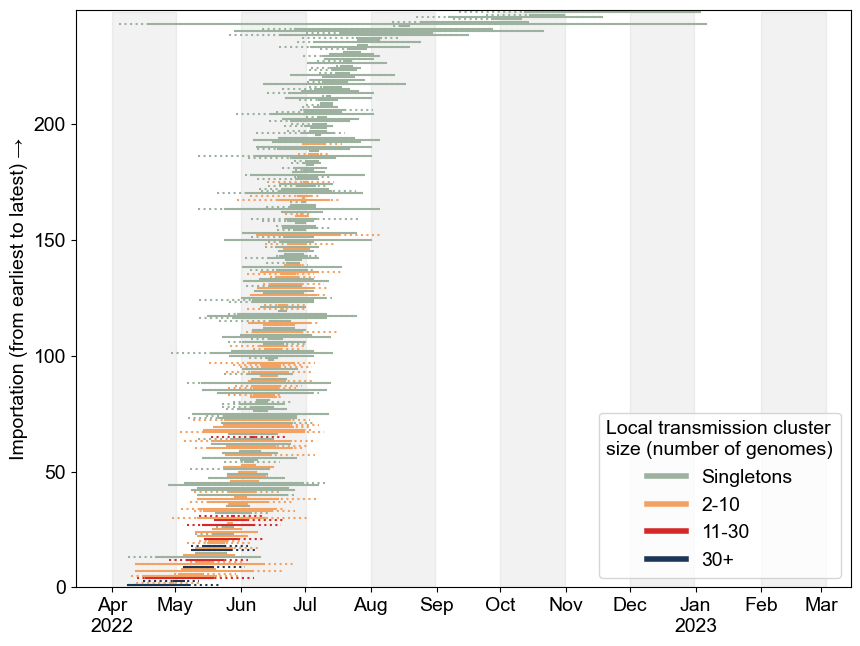

In [5]:
def plot_mcc_clusters_time(mcc_tree, mrcas, start_date=toYearFraction('2022-03-15'), end_date=toYearFraction('2022-10-01'), w_pad=4, fontsize=14, include_singletons=False, ax=None, cset = cmap3, linewidth=2, figsize=(10,5)):
    most_recent_sampling_date = 1900
    for n in mcc_tree.traverse_leaves():
        d = toYearFraction(n.label.strip("'").split('|')[-1])
        if d > most_recent_sampling_date:
            most_recent_sampling_date = d

    mrcas_adjusted = []
    for mrca in mrcas:
        if not include_singletons and mrca[-1] == 1:
            continue
        # if mrca[-1] == 1:
        #     continue
        mrca_adjusted = (most_recent_sampling_date - mrca[0], most_recent_sampling_date - mrca[1], most_recent_sampling_date - mrca[2], most_recent_sampling_date - mrca[3], mrca[4])
        mrcas_adjusted.append(mrca_adjusted)

    # sort mrcas by height of mrca[0]
    mrcas_adjusted.sort(key=lambda x: x[0], reverse=False)
    # sort mrcas be average of mrca[0] and mrca[1]
    mrcas_adjusted.sort(key=lambda x: (x[0]+x[1])/2, reverse=False)

    # color mrca by cluster size
    def color_mrca(mrca):
        if mrca[-1] == 1:
            return cset[0]
        elif mrca[-1] >= 2 and mrca[-1] <= 10:
            return cset[1]
        elif mrca[-1] >= 11 and mrca[-1] < 30:
            return cset[2]
        elif mrca[-1] >= 30:
            return cset[3]

    # plot start and end of each mrca
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    # set blank white face for background    
    ax.set_facecolor('white')
    # remove grid 
    ax.grid(False)
    for index, mrca in enumerate(mrcas_adjusted):
        # print(mrca)
        clust = index + 1
        col = color_mrca(mrca)
        ax.plot([mrca[2], mrca[3]], [clust, clust], color=col, linewidth=linewidth, linestyle=':')
        ax.plot([mrca[0], mrca[1]], [clust, clust], color=col, linewidth=linewidth)
        # add small vertical lines at the start and end of each mrca
        # ax.plot([mrca[0], mrca[0]], [clust-0.2, clust+0.2], color=col, linewidth=1)
        # ax.plot([mrca[1], mrca[1]], [clust-0.2, clust+0.2], color=col, linewidth=1)

    # set ylabel, with a long arrow at the end
    ax.set_ylabel('Importation (from earliest to latest) →', fontsize=fontsize)
    
    ax.set_ylim(0, len(mrcas_adjusted)+1)

    # make xticks at 2 week intervals from 2022.2 to 2022.9
    xticks = np.arange(2022.25, 2022.85, 1/26)
    xticklabels = [toDatestring(x) for x in xticks]
    xticks_months = ['2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01']
    xticklabels_months = ['Apr\n2022', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan\n2023', 'Feb', 'Mar']
    xticks = np.array([toYearFraction(x) for x in xticks_months])
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels_months, ha='center')

    # set xtick and ytick font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # add vertical grey bars at every month interval
    for index, x in enumerate(xticks):
        if index % 2 == 0:
            ax.fill_between([x, x+1/12], 0, len(mrcas_adjusted), color='grey', alpha=0.1)


    ax.set_xlim(start_date, end_date)
    # add legend 
    if not include_singletons:
        legend_elements = [Line2D([0], [0], color=cset[1], lw=4, label='2-10'),
                        Line2D([0], [0], color=cset[2], lw=4, label='11-30'),
                        Line2D([0], [0], color=cset[3], lw=4, label='30+')]
    elif include_singletons:
        legend_elements = [Line2D([0], [0], color=cset[0], lw=4, label='Singletons'),
                        Line2D([0], [0], color=cset[1], lw=4, label='2-10'),
                        Line2D([0], [0], color=cset[2], lw=4, label='11-30'),
                        Line2D([0], [0], color=cset[3], lw=4, label='30+')]
    ax.legend(handles=legend_elements, title='Local transmission cluster\nsize (number of genomes)', fontsize=fontsize, title_fontsize=fontsize, loc='lower right')

    ax.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
    ax.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)


def plot_clusters_bar(import_clusters, inset_min_cluster_size=5, include_singletons=False, ax=None, fontsize=14):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # plot the cluster size distribution
    if include_singletons:
        cluster_sizes = [len(cluster) for cluster in import_clusters]
    else:
        cluster_sizes = [len(cluster) for cluster in import_clusters if len(cluster) > 1]
    
    # max size is max cluster size rounded to nearest 5 
    xmax = max(cluster_sizes)
    xmax = xmax + (5 - xmax % 5)
    
    sns.set_style('white')
    ax.set_facecolor('white')
    ax.hist(cluster_sizes, bins=range(0, max(cluster_sizes) + 1, 1), color=tc.tol_cset('bright')[0], alpha=0.5, label='MPXV')
    ax.set_xlim(0, xmax)

    # set xtick and ytick font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    sns.set_style('white')
    # add a zoomed in inset
    axins = ax.inset_axes([0.3, 0.6, 0.65, 0.35])
    axins.hist(cluster_sizes, bins=range(0, max(cluster_sizes) + 1, 1), color=tc.tol_cset('bright')[0], alpha=0.5)
    axins.set_ylim(0, 6)
    axins.set_xticks(range(inset_min_cluster_size, max(cluster_sizes) + 1, 10))
    axins.set_xlim(inset_min_cluster_size, xmax)
    # axins.set_yticks(range(0, 13, 2))
    ax.indicate_inset_zoom(axins)

    ax.set_xlabel('Cluster size', fontsize=fontsize)
    ax.set_ylabel('Number of clusters', fontsize=fontsize)

    # remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # view major and minor ticks
    ax.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
    ax.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)
    axins.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
    axins.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)


cset=[cmap3[1], cmap3[0], cmap3[2], cmap3[3]][::-1]
plot_mcc_clusters_time(mcc_tree, mrcas, start_date=toYearFraction('2022-03-15'), end_date=toYearFraction('2023-03-15'), fontsize=14, include_singletons=True, cset=cset, linewidth=1.5, figsize=(10, 7.5))

# Imports and exports

In [6]:
def create_window_series_list(l, most_recent_sampling_date, window_size=7, final_date=2021, by_month=False):
    '''
    Initialize a dictionary of windows based on the most recent sampling date. This only needs to be done once per tree.
    
    Parameters
    ----------
    l : list
        A list of treeswift tree objects
    window: int
        The number of days to use as the window for calculating coalescent times
    final_date: int
        The final date to use as a key in the window dictionary
    most_recent_sampling_date: int
        The most recent sampling date in the list of trees

    Returns
    -------
    window_dict: dict
        A dictionary of windows with keys ranging from the most recent sampling date to the final date and values of empty lists
    '''

    if not by_month:
        # Initialize the dictionary with the most recent sampling date and make keys for each window
        current_date = most_recent_sampling_date
        window_dict = {current_date: []}
        while current_date > final_date:
            current_date -= window_size/365
            window_dict[current_date] = []

        # loop through list and add to the window dictionary
        for w in window_dict:
            for time in l:
                if time > w and (time - w <= window_size/365):
                    window_dict[w].append(time)
    
    else:
        # Initialize the dictionary with the most recent sampling date and make keys for each window
        current_date = most_recent_sampling_date

        # convert to datestring
        current_date = toDatestring(current_date)
        
    return window_dict


def create_window_series_list(l, most_recent_sampling_date, window_size=7, final_date=2021, by_month=False):
    '''
    Initialize a dictionary of windows based on the most recent sampling date. This only needs to be done once per tree.
    
    Parameters
    ----------
    l : list
        A list of treeswift tree objects
    window: int
        The number of days to use as the window for calculating coalescent times
    final_date: int
        The final date to use as a key in the window dictionary
    most_recent_sampling_date: int
        The most recent sampling date in the list of trees

    Returns
    -------
    window_dict: dict
        A dictionary of windows with keys ranging from the most recent sampling date to the final date and values of empty lists
    '''

    if not by_month:
        # Initialize the dictionary with the most recent sampling date and make keys for each window
        current_date = most_recent_sampling_date
        window_dict = {current_date: []}
        while current_date > final_date:
            current_date -= window_size/365
            window_dict[current_date] = []

        # loop through list and add to the window dictionary
        for w in window_dict:
            for time in l:
                if time > w and (time - w <= window_size/365):
                    window_dict[w].append(time)
    
    else:
        current_date = most_recent_sampling_date

        # convert to datestring
        current_date = datetime.strptime(toDatestring(current_date), '%Y-%m-%d')
        final_date = datetime.strptime(toDatestring(final_date), '%Y-%m-%d')

        # round down to the nearest month
        current_date = current_date.replace(day=1)
        final_date = final_date.replace(day=1)

        # initialize the dictionary with the most recent sampling date and make keys for each window
        window_dict = {current_date: []}
        while current_date > final_date:
            current_date -= relativedelta(months=1)
            window_dict[current_date] = []
        
        # loop through list and add to the window dictionary
        for w in window_dict:
            for time in l:
                time_datestring = datetime.strptime(toDatestring(time), '%Y-%m-%d')
                next_month = w + relativedelta(months=1)
                if time_datestring >= w and time_datestring < next_month:
                    window_dict[w].append(time)

    return window_dict


    

def date_nodes(tree):
    '''
    Date each internal node based on the most recent sampling date in the tree

    Parameters
    ----------
    tree: treeswift tree object

    Returns
    -------
    None
    '''

    most_recent_sampling_date = 1900
    for n in tree.traverse_leaves():
        d = toYearFraction(n.label.strip("'").split('|')[-1])
        if d > most_recent_sampling_date:
            most_recent_sampling_date = d

    for n in tree.traverse_preorder():
        if n.is_root():
            n.node_params += ',date=' + str(most_recent_sampling_date - tree.height())
        elif not n.is_leaf():
            parent_date = float(n.parent.node_params.split(',')[1].split('=')[1])
            n.node_params += ',date=' + str(parent_date + n.edge_length)
        elif n.is_leaf():
            n.node_params += ',date=' + str(toYearFraction(n.label.strip("'").split('|')[-1]))



def custom_preorder_traversal_internal_with_loc(root, loc):
    '''
    Perform a preorder traversal to identify introductions to a specific location 

    Parameters
    ----------
    root: node object corresponding to the root of a treeswift tree
    loc: str
        The location of interest

    Returns
    -------
    result: list
        A list of node objects corresponding to introductions to the specified location
    '''
    result = []
    stack = [root]

    while stack:
        node = stack.pop()

        if node.is_leaf():
            continue
        
        # If the node has the specified label, add it to the result list and do not traverse down the branch
        if 'node_params' in dir(node):
            if loc in node.node_params:
                result.append(node)
                continue

        # Push child nodes onto the stack in reverse order (right to left) to ensure proper preorder traversal
        stack.extend(reversed(node.children))

    return result


def imports_exports_over_time(tree, loc='NYC'):
    '''
    Calculate the number of imports and exports over time for a tree

    Parameters
    ----------
    tree: treeswift tree object
    loc: str
        The location of interest

    Returns
    -------
    imports: list
        A list of tuples containing the date of an import and the number of imports up to that date
    exports: list
        A list of tuples containing the date of an export and the number of exports up to that date
    '''

    date_nodes(tree)
    
    imports = []
    exports = []
    for n in tree.traverse_preorder():
        # skip leaves and root 
        if n.is_leaf():
            continue
        else:
            n_loc = n.node_params.split(',')[0].split('=')[1].strip('"')
            for c in n.child_nodes():
                c_loc = c.node_params.split(',')[0].split('=')[1].strip('"')
                time = float(c.node_params.split(',')[1].split('=')[1]) - c.edge_length/2
                if n_loc == loc and c_loc != loc:
                    exports.append((time, c_loc))
                elif n_loc != loc and c_loc == loc:
                    imports.append((time, n_loc))

    # sort imports and exports by first value
    imports = sorted(imports, key=lambda x: x[0])
    exports = sorted(exports, key=lambda x: x[0])

    return sorted(imports), sorted(exports)


def all_imports_exports_over_time(trees, loc='NYC', by_month=False):
    '''
    Calculate the number of imports and exports over time for a list of trees

    Parameters
    ----------
    trees: list
        A list of treeswift tree objects
    loc: str
        The location of interest
    by_month: bool
        Whether to calculate imports and exports by month

    Returns
    -------
    imports: list
        A list of tuples containing the date of an import and the number of imports up to that date
    exports: list
        A list of tuples containing the date of an export and the number of exports up to that date
    '''

    imports = []
    exports = []
    count = 0
    for key in trees:
        if 'STATE' not in key:
            continue
        tree = trees[key].extract_subtree(trees[key].root)
        tree_imports, tree_exports = imports_exports_over_time(tree, loc)
        imports.append(tree_imports)
        exports.append(tree_exports)
        # count += 1
        # if count > 3:
        #     break

    # get the most recent sampling date
    most_recent_sampling_date = 1900
    for n in tree.traverse_leaves():
        d = toYearFraction(n.label.strip("'").split('|')[-1])
        if d > most_recent_sampling_date:
            most_recent_sampling_date = d

    # get all regions
    regions = set()
    for imp in imports:
        for i in imp:
            regions.add(i[1])
    for exp in exports:
        for e in exp:
            regions.add(e[1])

    # create a dictionary for each region for imports and exports
    imports_dict = {}
    exports_dict = {}
    for region in regions:
        imports_dict[region] = []
        exports_dict[region] = []

    # add imports and exports to the appropriate dictionary
    for imp in imports:
        # extend the list of imports for each region
        for region in regions:
            imports_dict[region].append([])
        for i in imp:
            imports_dict[i[1]][-1].append(i[0])
    for exp in exports:
        # extend the list of exports for each region
        for region in regions:
            exports_dict[region].append([])
        for e in exp:
            exports_dict[e[1]][-1].append(e[0])

    # sort each list of imports and exports by date
    for region in regions:
        for i in range(len(imports_dict[region])):
            imports_dict[region][i] = sorted(imports_dict[region][i])
        for i in range(len(exports_dict[region])):
            exports_dict[region][i] = sorted(exports_dict[region][i])

    # convert to time series
    for region in regions:
        for i in range(len(imports_dict[region])):
            imports_dict[region][i] = create_window_series_list(imports_dict[region][i], most_recent_sampling_date=most_recent_sampling_date, window_size=7, final_date=2021, by_month=by_month)
        for i in range(len(exports_dict[region])):
            exports_dict[region][i] = create_window_series_list(exports_dict[region][i], most_recent_sampling_date=most_recent_sampling_date, window_size=7, final_date=2021, by_month=by_month)

    return imports_dict, exports_dict


trees_path = '../../..//beast/new/pooled/mpox.global_B.1.cleaned_4.empirical.dta.burnin.resampled.trees'

trees = treeswift.read_tree_nexus(trees_path)
imports_nyc_dict, exports_nyc_dict = all_imports_exports_over_time(trees, loc='NYC', by_month=False)
imports_us_dict, exports_us_dict = all_imports_exports_over_time(trees, loc='USA', by_month=False)

# Plot imports and exports over time

In [7]:
def plot_imports_exports_over_time(imports_dict, exports_dict, start_date=2020, end_date=2021, colors=cmap3, figsize=(15, 5), width_ratios=[2.5, 1], w_pad=4, fontsize=14, cum_sum_height=200, axes=None, alpha=0.5, linewidth=2):
    '''
    Plot the number of imports and exports over time

    Parameters
    ----------
    imports_dict: dict
        A dictionary of lists of imports over time for each region
    exports_dict: dict
        A dictionary of lists of exports over time for each region

    Returns
    -------
    None
    '''

    
    regions = ['NYC', 'USA', 'nonUSA']
    regions = [x for x in regions if x in imports_dict.keys()]

    # get all dates
    dates = list(imports_dict[regions[0]][0].keys())

    colors_dict = {'NYC': colors[0],
                   'United States': colors[1],
                   'Global': colors[2]}

    # create region-date-value 3-d matrices for imports and exports
    imports_matrix = np.zeros((len(regions), len(dates), len(imports_dict[regions[0]])))
    exports_matrix = np.zeros((len(regions), len(dates), len(exports_dict[regions[0]])))

    # fill in the matrices
    for i in range(len(regions)):
        for j in range(len(dates)):
            for k in range(len(imports_dict[regions[0]])):
                imports_matrix[i][j][k] = len(imports_dict[regions[i]][k][dates[j]])
                exports_matrix[i][j][k] = len(exports_dict[regions[i]][k][dates[j]])

    # calculate median and 95% HPD for imports and exports for each region and each date
    imports_median = np.zeros((len(regions), len(dates)))
    imports_hpd_lower = np.zeros((len(regions), len(dates)))
    imports_hpd_upper = np.zeros((len(regions), len(dates)))
    exports_median = np.zeros((len(regions), len(dates)))
    exports_hpd_lower = np.zeros((len(regions), len(dates)))
    exports_hpd_upper = np.zeros((len(regions), len(dates)))

    for i in range(len(regions)):
        for j in range(len(dates)):
            imports_median[i][j] = np.median(imports_matrix[i][j])
            imports_hpd_lower[i][j], imports_hpd_upper[i][j] = hpd_single(imports_matrix[i][j], 0.05)
            exports_median[i][j] = np.median(exports_matrix[i][j])
            exports_hpd_lower[i][j], exports_hpd_upper[i][j] = hpd_single(exports_matrix[i][j], 0.05)
            
    # calculate total imports and exports 
    imports_total = np.zeros(len(imports_dict[regions[0]]))
    exports_total = np.zeros(len(exports_dict[regions[0]]))

    for i in range(len(imports_dict[regions[0]])):
        imports_total[i] = sum([len(x) for x in (imports_dict[regions[0]][i].values())]) + sum([len(x) for x in (imports_dict[regions[1]][i].values())])
        exports_total[i] = sum([len(x) for x in (exports_dict[regions[0]][i].values())]) + sum([len(x) for x in (exports_dict[regions[1]][i].values())])

    # calculate medinan and 95% HPD for total imports and exports
    imports_total_median = np.median(imports_total)
    imports_total_hpd_lower, imports_total_hpd_upper = hpd_single(imports_total, 0.05)
    exports_total_median = np.median(exports_total)
    exports_total_hpd_lower, exports_total_hpd_upper = hpd_single(exports_total, 0.05)

    # print total imports and exports
    print('Total imports: %i (%i - %i)' % (imports_total_median, imports_total_hpd_lower, imports_total_hpd_upper))
    print('Total exports: %i (%i - %i)' % (exports_total_median, exports_total_hpd_lower, exports_total_hpd_upper))

    # calculate region-value 2-d matrices for imports and exports
    imports_matrix_sum = np.zeros((len(regions), len(imports_dict[regions[0]])))
    exports_matrix_sum = np.zeros((len(regions), len(exports_dict[regions[0]])))

    # fill in the matrices
    for i in range(len(regions)):
        for j in range(len(imports_dict[regions[0]])):
            imports_matrix_sum[i][j] = (sum([len(x) for x in (imports_dict[regions[i]][j].values())]))
            exports_matrix_sum[i][j] = (sum([len(x) for x in (exports_dict[regions[i]][j].values())]))

    # make into dataframe for violinplot
    imports_matrix_sum = pd.DataFrame(imports_matrix_sum, index=regions).T
    exports_matrix_sum = pd.DataFrame(exports_matrix_sum, index=regions).T

    # melt the dataframes 
    imports_matrix_sum = pd.melt(imports_matrix_sum, var_name='Region', value_name='Number')
    imports_matrix_sum['Region'] = imports_matrix_sum['Region'].apply(lambda x: (x + ' imports').replace('nonUSA', 'Global').replace('USA', 'United States'))
    exports_matrix_sum = pd.melt(exports_matrix_sum, var_name='Region', value_name='Number')
    exports_matrix_sum['Region'] = exports_matrix_sum['Region'].apply(lambda x: (x + ' exports').replace('nonUSA', 'Global').replace('USA', 'United States'))

    # concat the dataframes and sort
    imports_exports_matrix_sum = pd.concat([imports_matrix_sum, exports_matrix_sum])
    order = ['Global imports', 'Global exports', 'United States imports', 'United States exports', 'NYC imports', 'NYC exports']
    order = [x for x in order if x in imports_exports_matrix_sum['Region'].unique()]
    imports_exports_matrix_sum['Region'] = pd.Categorical(imports_exports_matrix_sum['Region'], categories=order)
    
    regions = ['NYC', 'United States', 'Global']
    updated_regions = set([' '.join(x.split(' ')[0:-1]) for x in imports_exports_matrix_sum['Region'].unique()])
    regions = [x for x in regions if x in updated_regions]

    # plot imports and exports over time for each region; make left plot 3x as wide as right plot
    if axes is None:
        fig, ax = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': width_ratios})
    sns.set_style('white')
    custom_legend = []
    for i in range(len(regions)):
        # print(regions[i], i)
        axes[0].plot(dates, imports_median[i], color=colors_dict.get(regions[i]), linestyle='-', label = regions[i] + ' imports', linewidth=linewidth)
        axes[0].fill_between(dates, imports_hpd_lower[i], imports_hpd_upper[i], color=colors_dict.get(regions[i]), alpha=0.1)
        axes[0].plot(dates, exports_median[i], color=colors_dict.get(regions[i]), linestyle='--', label = regions[i] + ' exports', linewidth=linewidth)
        axes[0].fill_between(dates, exports_hpd_lower[i], exports_hpd_upper[i], color=colors_dict.get(regions[i]), alpha=0.1)

    axes[0].legend(loc='upper right', fontsize=fontsize)

    # xticks
    xticks = np.arange(start_date, end_date, 1/26)
    xticklabels = [toDatestring(x) for x in xticks]
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xticklabels, rotation=90, ha='center')
    
    # ax[0].set_xlabel('Date')
    axes[0].set_ylabel('Weekly count', fontsize=fontsize)

    xticks_months = ['2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01']
    xticklabels_months = ['Apr\n2022', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan\n2023']
    xticks = [toYearFraction(x) for x in xticks_months]
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xticklabels_months, rotation=0, ha='center')
    axes[0].set_xlim([start_date, end_date])

    # make xticks visible
    axes[0].tick_params(axis='x', which='major', labelsize=fontsize)
    axes[0].tick_params(axis='y', which='major', labelsize=fontsize)

    # add vertical grey bars at every month interval
    for index, x in enumerate(xticks):
        if index % 2 == 0:
            axes[0].fill_between([x, x+1/12], 0, 100, color='grey', alpha=0.1)
    axes[0].set_ylim([0, 40])

    # extract median for each region and imports/exports in imports_exports_matrix_sum
    imports_exports_matrix_sum_median = imports_exports_matrix_sum.groupby('Region').apply(lambda x: np.median(x['Number']))
    # extract 95% HPD for each region and imports/exports in imports_exports_matrix_sum
    imports_exports_matrix_sum_hpd_bounds = imports_exports_matrix_sum.groupby('Region').apply(lambda x: hpd_single(x['Number'], 0.05))
    # now limit values in imports_exports_matrix_sum to 95% HPD
    imports_exports_matrix_sum_hpd = imports_exports_matrix_sum.groupby('Region').apply(lambda x: x[(x['Number'] >= imports_exports_matrix_sum_hpd_bounds[x.name][0]) & (x['Number'] <= imports_exports_matrix_sum_hpd_bounds[x.name][1])])
    # drop categories
    imports_exports_matrix_sum_hpd = imports_exports_matrix_sum_hpd.reset_index(drop=True)

    print(imports_exports_matrix_sum_median)
    print(imports_exports_matrix_sum_hpd_bounds)

    # plot imports and exports over time for each region
    ax_violins = sns.violinplot(x='Region', y='Number', 
                                data=imports_exports_matrix_sum_hpd, ax=axes[1], cut=0, 
                                palette=[colors_dict.get(regions[1]), 
                                         colors_dict.get(regions[1]), 
                                         colors_dict.get(regions[0]), 
                                         colors_dict.get(regions[0])], 
                                inner=None, alpha=alpha)


    # Overlay medians as lines
    for xtick in ax_violins.get_xticks():
        region = ax_violins.get_xticklabels()[xtick].get_text()
        median_val = imports_exports_matrix_sum_median[region]
        
        # Plot the median line, adjusting it based on the maximum width of the violins
        ax_violins.plot([xtick - 0.2, xtick + 0.2], [median_val, median_val], color='black', linewidth=2)

    axes[1].set_xticklabels([x.replace(' ', '\n') for x in order], fontsize=fontsize)
    # ax[1].set_xticklabels(['Imports', 'Exports', 'Imports', 'Exports'], fontsize=fontsize)
    axes[1].set_xlabel(None)
    axes[1].set_ylabel('Cumulative importations\nand exportations', fontsize=fontsize)
    axes[1].set_ylim([0, 200])


    # add major ticks to x-axis and y-axis
    axes[1].set_xticks(np.arange(0, 4, 1))
    axes[1].set_yticks(np.arange(0, cum_sum_height, 25))
    axes[1].set_ylim([0, cum_sum_height])

    # remove right and top borders
    # ax[0].spines['right'].set_visible(False)
    # ax[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)

    # show major and minor ticks
    axes[0].xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
    axes[0].yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)
    axes[1].xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
    axes[1].yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)

    # remove gridlines
    # ax[0].grid(False)
    # ax[1].grid(False)

    # add hspace between subplots
    if axes is None:
        plt.tight_layout(w_pad=w_pad)
        plt.show()


def plot_clusters_bar(import_clusters, inset_min_cluster_size=5, include_singletons=False, ax=None, fontsize=14):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # plot the cluster size distribution
    if include_singletons:
        cluster_sizes = [len(cluster) for cluster in import_clusters]
    else:
        cluster_sizes = [len(cluster) for cluster in import_clusters if len(cluster) > 1]
    
    # max size is max cluster size rounded to nearest 5 
    xmax = max(cluster_sizes)
    xmax = xmax + (5 - xmax % 5)
    
    sns.set_style('white')
    ax.set_facecolor('white')
    ax.hist(cluster_sizes, bins=range(0, max(cluster_sizes) + 1, 1), color=tc.tol_cset('bright')[0], alpha=0.5, label='MPXV')
    ax.set_xlim(0, xmax)

    # set xtick and ytick font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    sns.set_style('white')
    # add a zoomed in inset
    axins = ax.inset_axes([0.2, 0.5, 0.75, 0.45])
    axins.hist(cluster_sizes, bins=range(0, max(cluster_sizes) + 1, 1), color=tc.tol_cset('bright')[0], alpha=0.5)
    axins.set_ylim(0, 6)
    axins.set_xticks(range(inset_min_cluster_size, max(cluster_sizes) + 1, 10))
    axins.set_xlim(inset_min_cluster_size, xmax)
    # axins.set_yticks(range(0, 13, 2))
    ax.indicate_inset_zoom(axins)

    ax.set_xlabel('Cluster size', fontsize=fontsize)
    ax.set_ylabel('Number of clusters', fontsize=fontsize)

    # remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # view major and minor ticks
    ax.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
    ax.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)
    axins.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
    axins.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)

    # set fontsize of axins ticks
    axins.tick_params(axis='both', which='major', labelsize=fontsize)

    

Total imports: 234 (215 - 252)
Total exports: 211 (177 - 240)
Region
Global imports           174.0
Global exports            40.0
United States imports     59.0
United States exports    170.0
dtype: float64
Region
Global imports           [160.0, 191.0]
Global exports             [27.0, 52.0]
United States imports      [43.0, 75.0]
United States exports    [143.0, 193.0]
dtype: object


/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_27758/1422374413.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imports_exports_matrix_sum_median = imports_exports_matrix_sum.groupby('Region').apply(lambda x: np.median(x['Number']))
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_27758/1422374413.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imports_exports_matrix_sum_hpd_bounds = imports_exports_matrix_sum.groupby('Region').apply(lambda x: hpd_single(x['Number'], 0.05))
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_27758/1422374413.py:147: FutureWarning: The 

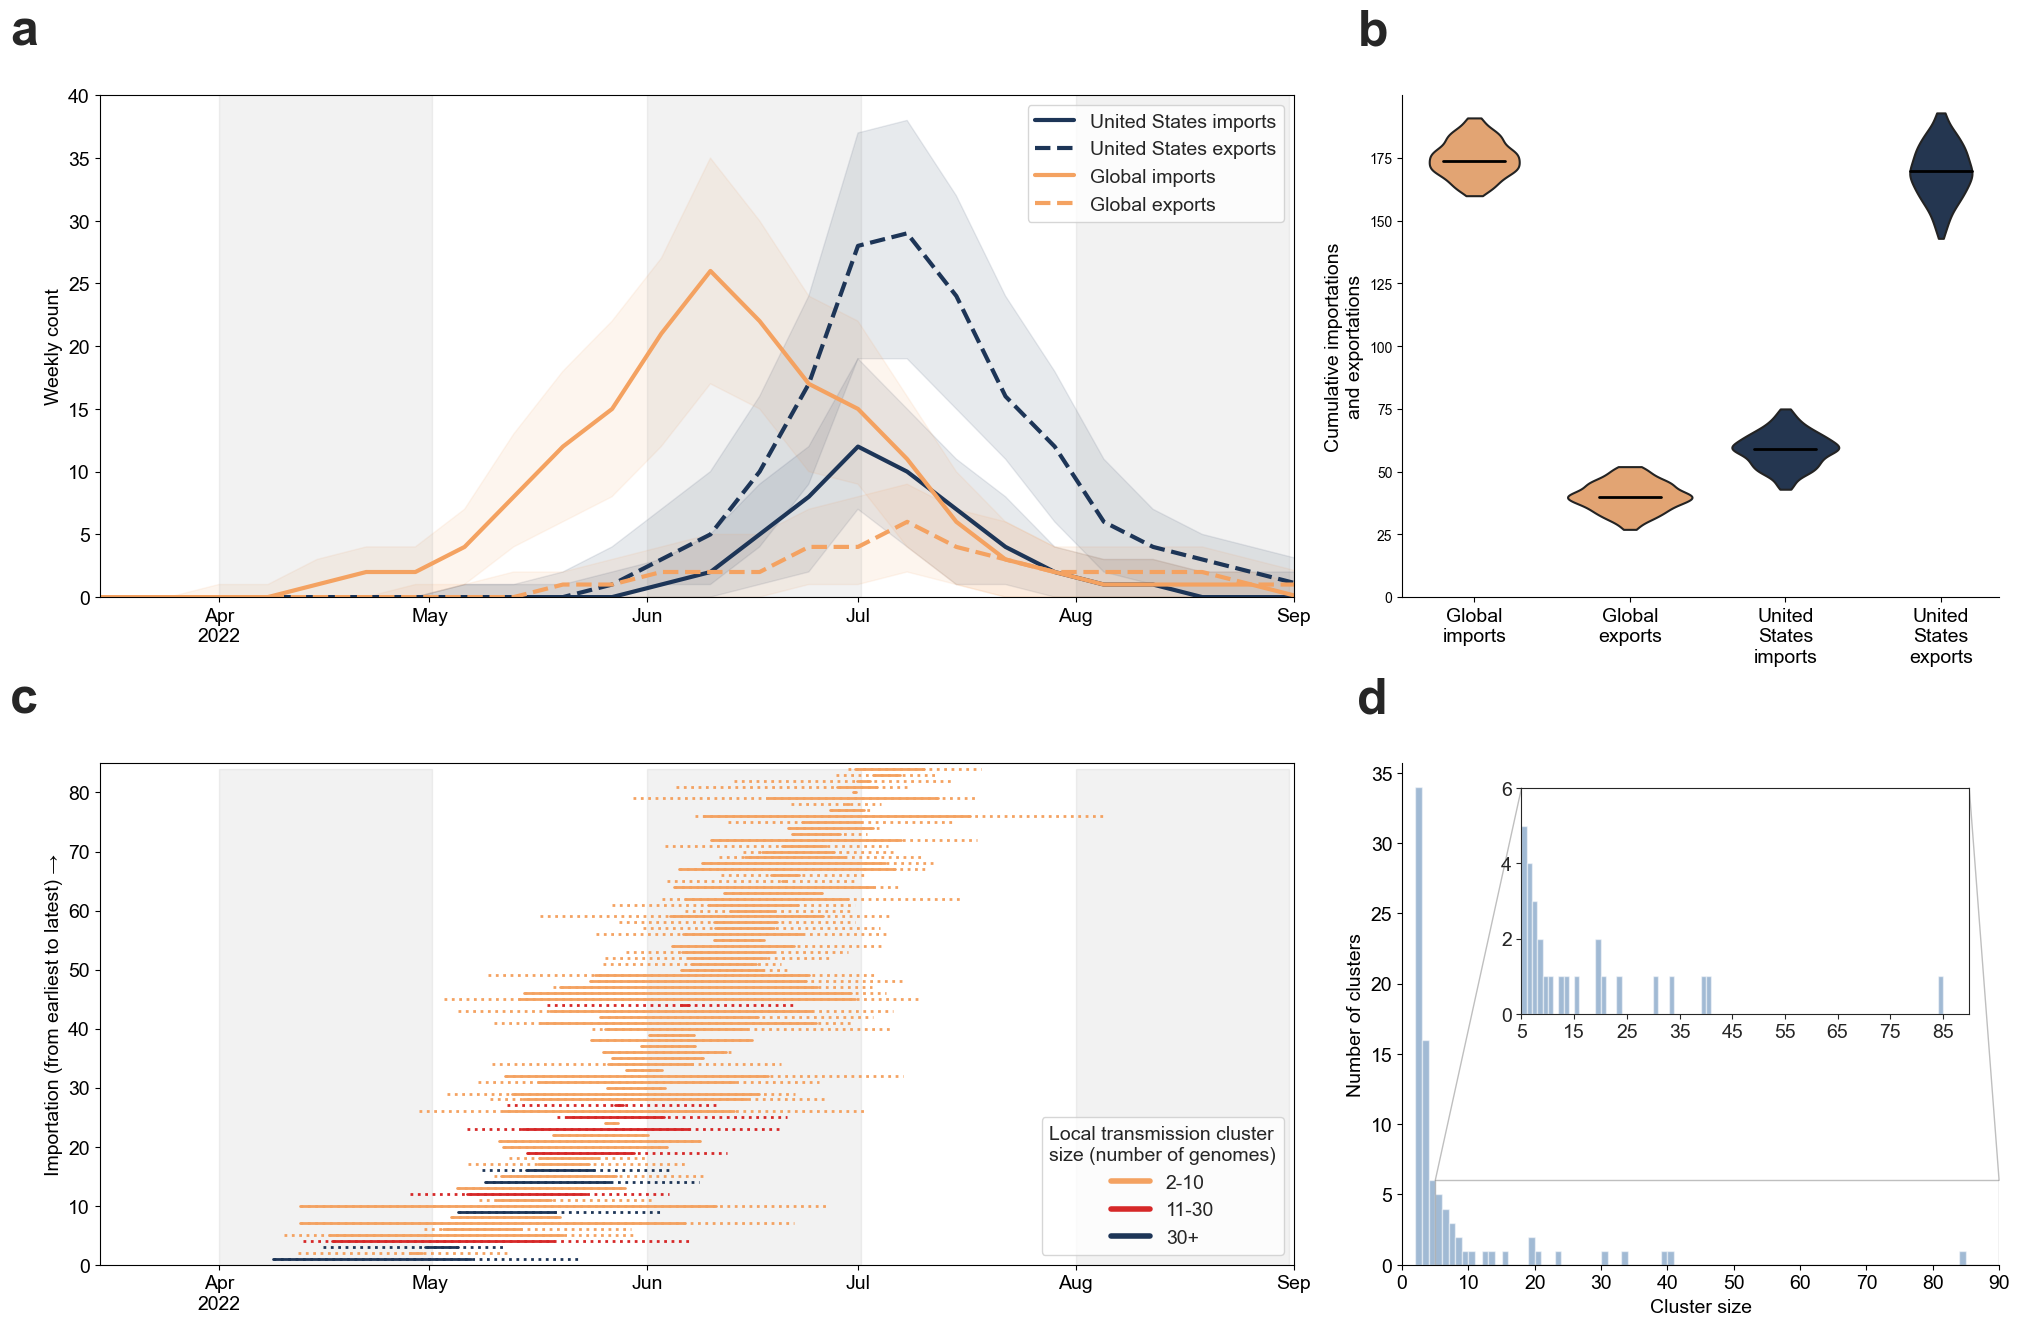

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 2*20/3), gridspec_kw={'width_ratios': [2, 1]})

plot_imports_exports_over_time(imports_nyc_dict, exports_nyc_dict, start_date=toYearFraction('2022-03-15'), end_date=toYearFraction('2022-09-01'), colors=cmap3, figsize=(20, 20/3), width_ratios=[2, 1], w_pad=4, fontsize=14, cum_sum_height=200, axes=[axes[0,0], axes[0,1]], linewidth=3)

cset=[cmap3[1], cmap3[0], cmap3[2], cmap3[3]][::-1]
plot_mcc_clusters_time(mcc_tree, mrcas, start_date=toYearFraction('2022-03-15'), end_date=toYearFraction('2022-09-01'), fontsize=14, include_singletons=False, ax=axes[1,0], cset=cset)

plot_clusters_bar(import_clusters_test, include_singletons=False, ax=axes[1,1], fontsize=14, inset_min_cluster_size=5)

# add panel labels
for i, ax in enumerate(axes.flatten()):
    ax.text(-0.075, 1.1, string.ascii_lowercase[i], transform=ax.transAxes, size=36, weight='bold')

plt.tight_layout(h_pad=1, w_pad=1)
# plt.savefig('../figures/Figure2.pdf', bbox_inches='tight', dpi=300)

Total imports: 396 (373 - 419)
Total exports: 109 (86 - 135)
Region
Global imports    227.0
Global exports     50.0
NYC imports       170.0
NYC exports        59.0
dtype: float64
Region
Global imports    [208.0, 246.0]
Global exports      [35.0, 63.0]
NYC imports       [143.0, 193.0]
NYC exports         [43.0, 75.0]
dtype: object


/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_27758/1422374413.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imports_exports_matrix_sum_median = imports_exports_matrix_sum.groupby('Region').apply(lambda x: np.median(x['Number']))
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_27758/1422374413.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imports_exports_matrix_sum_hpd_bounds = imports_exports_matrix_sum.groupby('Region').apply(lambda x: hpd_single(x['Number'], 0.05))
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_27758/1422374413.py:147: FutureWarning: The 

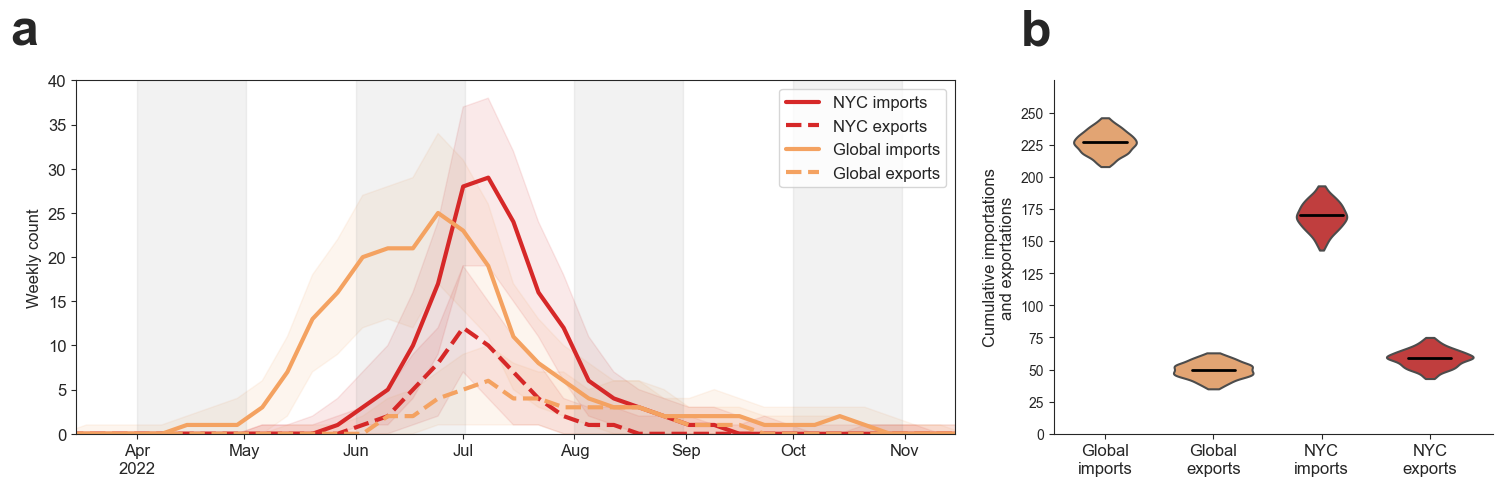

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]})
plot_imports_exports_over_time(imports_us_dict, exports_us_dict, start_date=toYearFraction('2022-03-15'), end_date=toYearFraction('2022-11-15'), colors=cmap3, figsize=(15, 5), width_ratios=[2, 1], w_pad=4, fontsize=12, cum_sum_height=275, axes=axes, linewidth=3)

# add panel labels
for i, ax in enumerate(axes.flatten()):
    ax.text(-0.075, 1.1, string.ascii_lowercase[i], transform=ax.transAxes, size=36, weight='bold')

plt.tight_layout(w_pad=2)